# ASTR 310 HW 8

## 1. Making a contour plot with annotations

**a)** Create a contour plot of the function
$$ z(x,y) = \frac{1}{|y|+1} \sin (x^2 + y^2) \; e^{-x^2}$$
containing 15 contour levels equally spaced between the global minimum and maximum of the function within the domain
$[-\pi, \pi] \times [-\pi, \pi]$.

**b)** Find all the local minima and maxima of $z$. Indicate positions of the minima with circles and positions of the maxima with $\times$'s. Finding local extrema is nontrivial, so there are two ways you might do this task.  The easy but inelegant way is to loop over all the pixels of z and check whether they are larger or smaller than all of their neighbors.  The more elegant way is to use tests like `(z >= np.roll(z, -1, axis=0))` to eliminate the loop.

**c)** Create a legend that shows that circles indicate minima and that $\times$'s indicate maxima. Be sure to include an appropriate title and labels for the $x$ and $y$ axes.


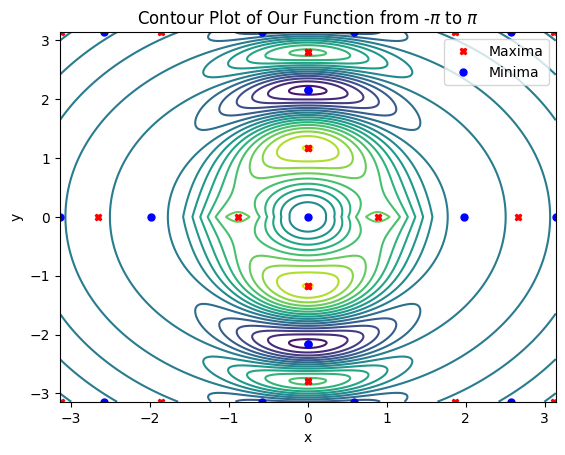

In [3]:
# Code here
import numpy as np
import matplotlib.pyplot as plt
#a)
xx=yy=np.linspace(-np.pi,np.pi,1000)
x,y = np.meshgrid(xx,yy)
def zfn(x,y):
    return (1/(np.abs(y)+1))*np.sin(np.square(x)+np.square(y))*(np.e**(-np.square(x)))
z=zfn(x,y)
lmin = (z <= np.roll(z,1,axis=0)) & \
        (z <= np.roll(z,-1,axis=0))& \
        (z <= np.roll(z,1,axis=1))& \
        (z <= np.roll(z,-1,axis=1))


lmax = (z >= np.roll(z,1,axis=0)) & \
        (z >= np.roll(z,-1,axis=0))& \
        (z >= np.roll(z,1,axis=1))& \
        (z >= np.roll(z,-1,axis=1))

miny,minx = np.where(lmin==True)
maxy,maxx = np.where(lmax==True)

plt.contour(x,y,z,15)

plt.plot(xx[maxx],yy[maxy],'rX',markersize=5,label = 'Maxima')
plt.plot(xx[minx],yy[miny],'bo',markersize=5,label = 'Minima')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Contour Plot of Our Function from -$\pi$ to $\pi$")
plt.show()




## 2. Reading and working with data in a FITS file

Note that some of the details and instructions have been omitted from this notebook.  For all of those details you must consult the PDF, which is the definitive version of the assignment.

**a)** Write code to read the file and select the data by photon energy so that you have a
NumPy record array containing (X,Y) positions for photons with energies between 2.0
and 9.5 keV.   You will need to convert the (X,Y) positions from the file into sky coordinates (RA, Dec) in degrees in the following way...


In [4]:
# Code here
from astropy.io import fits
file = fits.open('acisf26248N001_evt2.fits')[1]
data = file.data
header = file.header
datamask = data[(data['energy'] >= 2000) & (data['energy'] <= 9500)]
datax = datamask['x']
datay = datamask['y']

#X and Y axis reference pixels
TCRPX11 = header["TCRPX11"]
TCRPX12 = header["TCRPX12"]
#skycoord val for reference
TCRVL11 = header["TCRVL11"]
TCRVL12 = header["TCRVL12"]
#pixel size
TCDLT11 = header["TCDLT11"]
TCDLT12 = header["TCDLT12"]

energy = datamask['energy']

E = np.radians(TCDLT11) * (datax - TCRPX11)
N = np.radians(TCDLT12) * (datay - TCRPX12)
a0 = np.radians(TCRVL11)
d0 = np.radians(TCRVL12)
RA = np.degrees(a0 + np.arctan(E) / (np.cos(d0) - N*np.sin(d0)))
DEC = np.degrees(np.arcsin((np.sin(d0) +\
                             N*np.cos(d0))/np.sqrt(1+E**2+N**2)))


**b)** Write code to construct an image array from this selection; that is, produce a 2D mesh
covering the region of sky from which photons were received, and set the array values
equal to the number of photons that fell within each mesh cell. You can use `np.histogram2d` or you can do the gridding yourself by hand.

...

Divide the photon counts by the area of each cell in square arcseconds, the effective
area of the detector (assume it to be $600 {\rm\ cm}^2$; in reality it varies with photon energy
and position), and the “live time” of the observation.  (Use the LIVETIME keyword in the
EVENTS header to get this information.)  At the end of this operation you will have an image array containing values in units of photons arcsec$^{-2}$ cm$^{-2}$ sec$^{-1}$.

In [5]:
# Code here
ncells=128 #ncells = nbins 
counts,xedges,yedges = np.histogram2d(RA,DEC,bins=ncells)

cellA = ((np.max(RA) - np.min(RA)) / ncells * 3600) * \
    ((np.max(DEC) - np.min(DEC)) / ncells * 3600)
detector = 600
livetime = header['LIVETIME']
counts = np.flip(counts,0).T
image = counts / (cellA*detector*livetime)


**c)** Use the image array to produce a color image plot. The plot should have appropriate
axis ranges (remember units!) and labels and a title, and a color bar legend should be
included. Use whatever color palette you like.
By default `imshow` assumes the [0,0] element of the array is at the top left; use the `origin="lower"` argument to override this behavior.  Also, since Cas A is at a high Declination, to get the image to look square you will need to specify `aspect=R`, where R is (width in RA)/(width in Dec).  This scaling accounts for the fact that longitude lines get closer together towards the pole.

You might want to “stretch” the image to make faint features more visible by plotting,
e.g., the logarithm of the counts. If you do so, be sure to use the “unstretched” data in
the following steps.

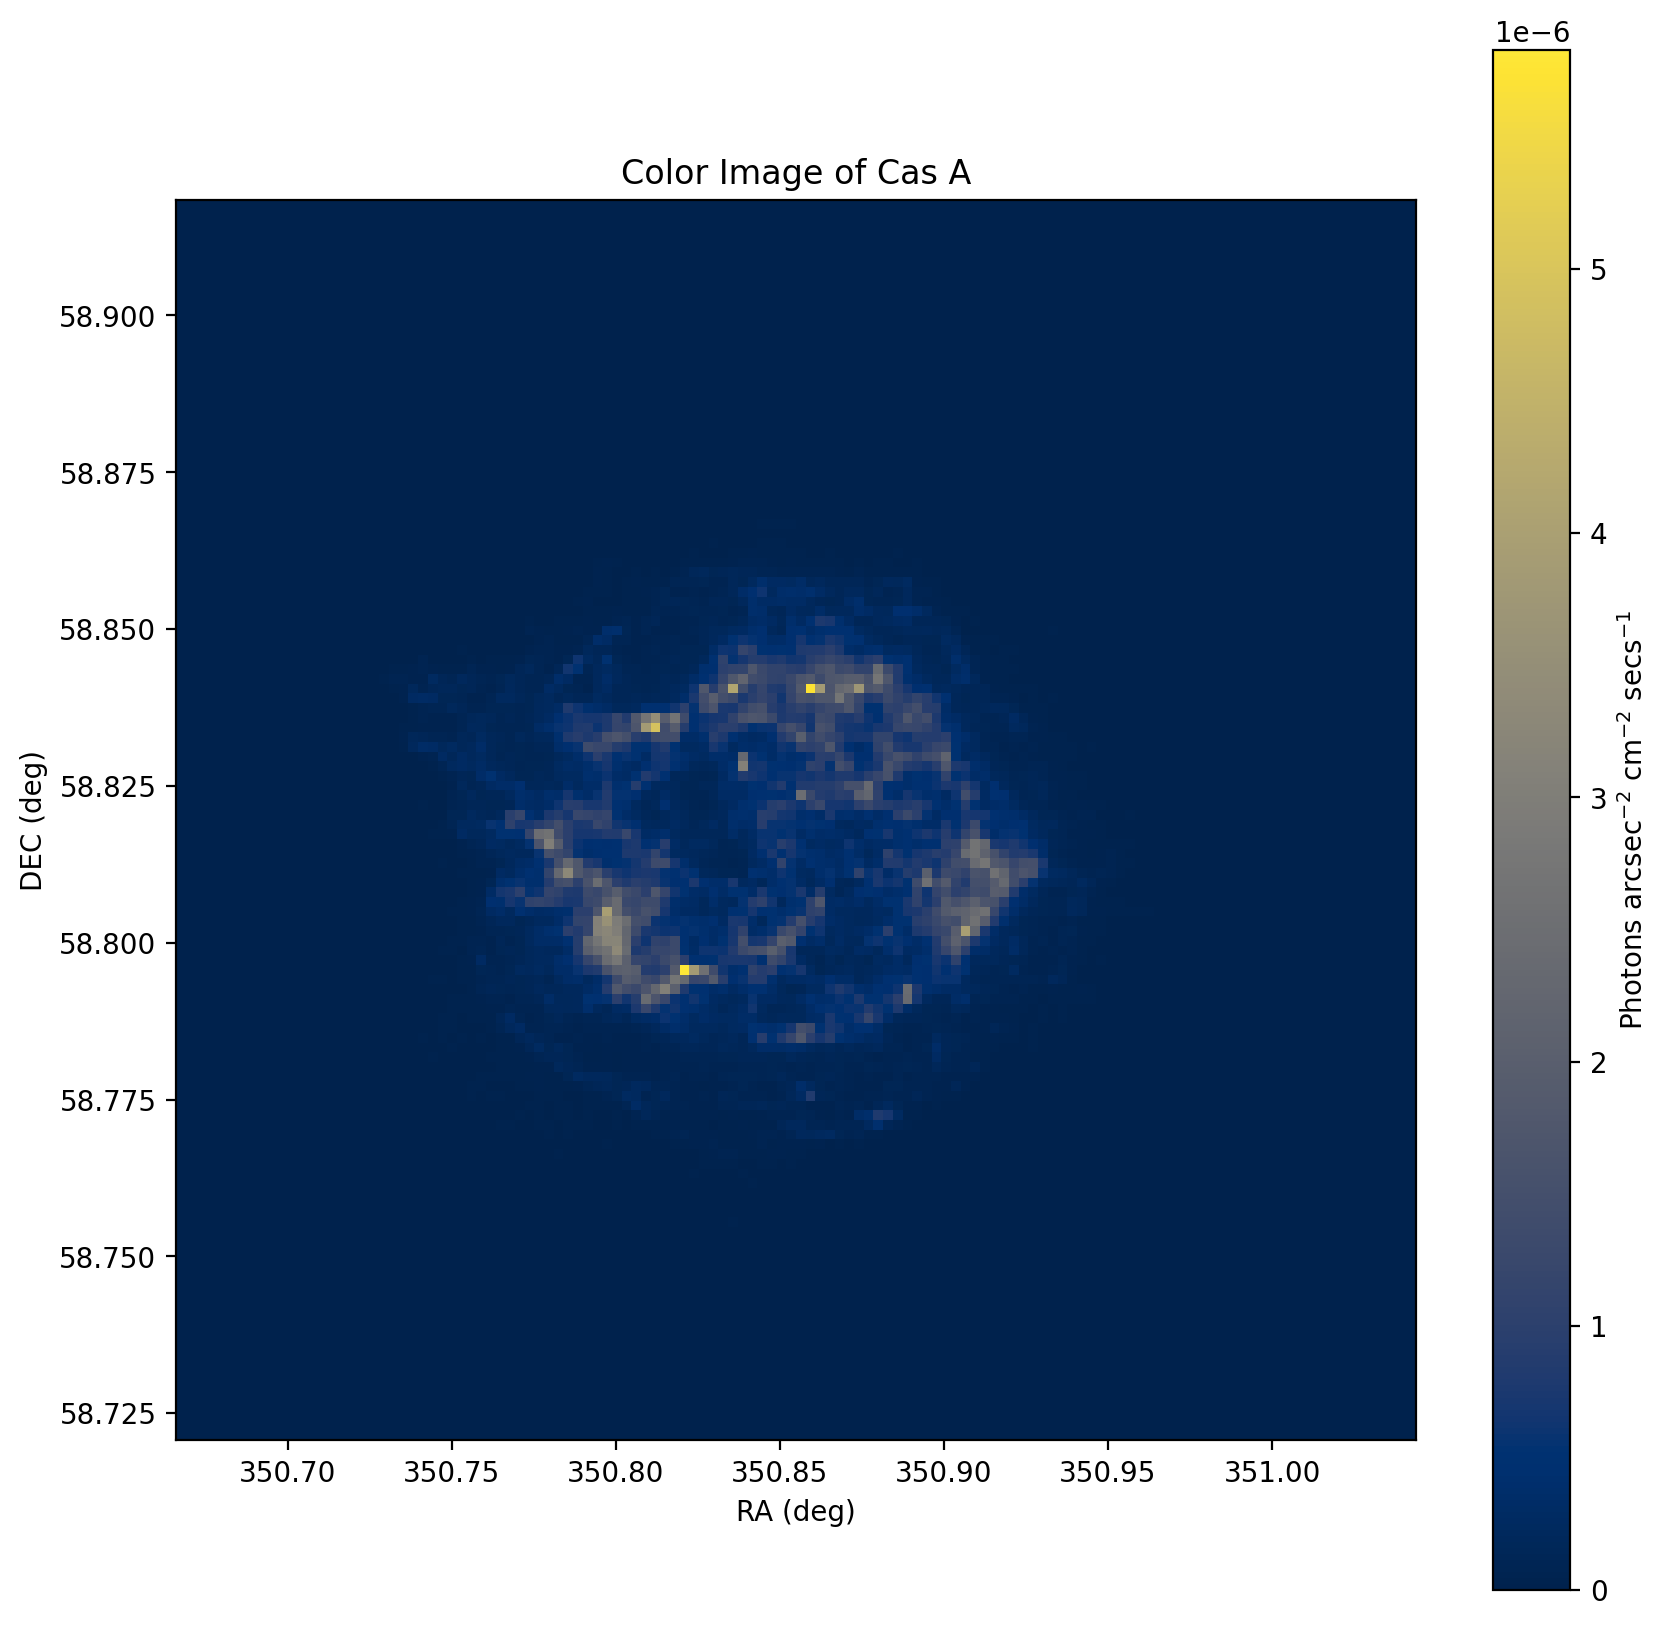

In [6]:
# Code here
plt.figure(figsize=(10,10),dpi=200)
R = (np.max(RA) - np.min(RA)) / (np.max(DEC) - np.min(DEC))
plt.imshow(image, cmap = 'cividis', origin = 'lower',\
           extent = [np.min(RA),np.max(RA),np.min(DEC),np.max(DEC)],\
            aspect = R)
plt.colorbar(label=r'Photons arcsec$^{-2}$ cm$^{-2}$ secs$^{-1}$',norm='log')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.title('Color Image of Cas A')
plt.show()

**d)** Designate two special regions “A” and “B” on the map. The “A” region should be a
circle of radius 2' centered on J2000 coordinates 23h23m24s, +58d48m54s. (Convert
these to decimal degrees to compare to photon positions.) The “B” region should be an
annulus centered on the same point with an inner radius of 2' and an outer radius of 3'.
Have your code draw the outline of each region on the image and label the outlines
appropriately (“A”, “B”). Because of the aspect ratio mentioned in (c), to make your
circles look circular you will need to plot them as ellipses. For example, for region “A”
you would use an ellipse of width 2 x 2'/$\cos \delta_0$ and height 2 x 2'.

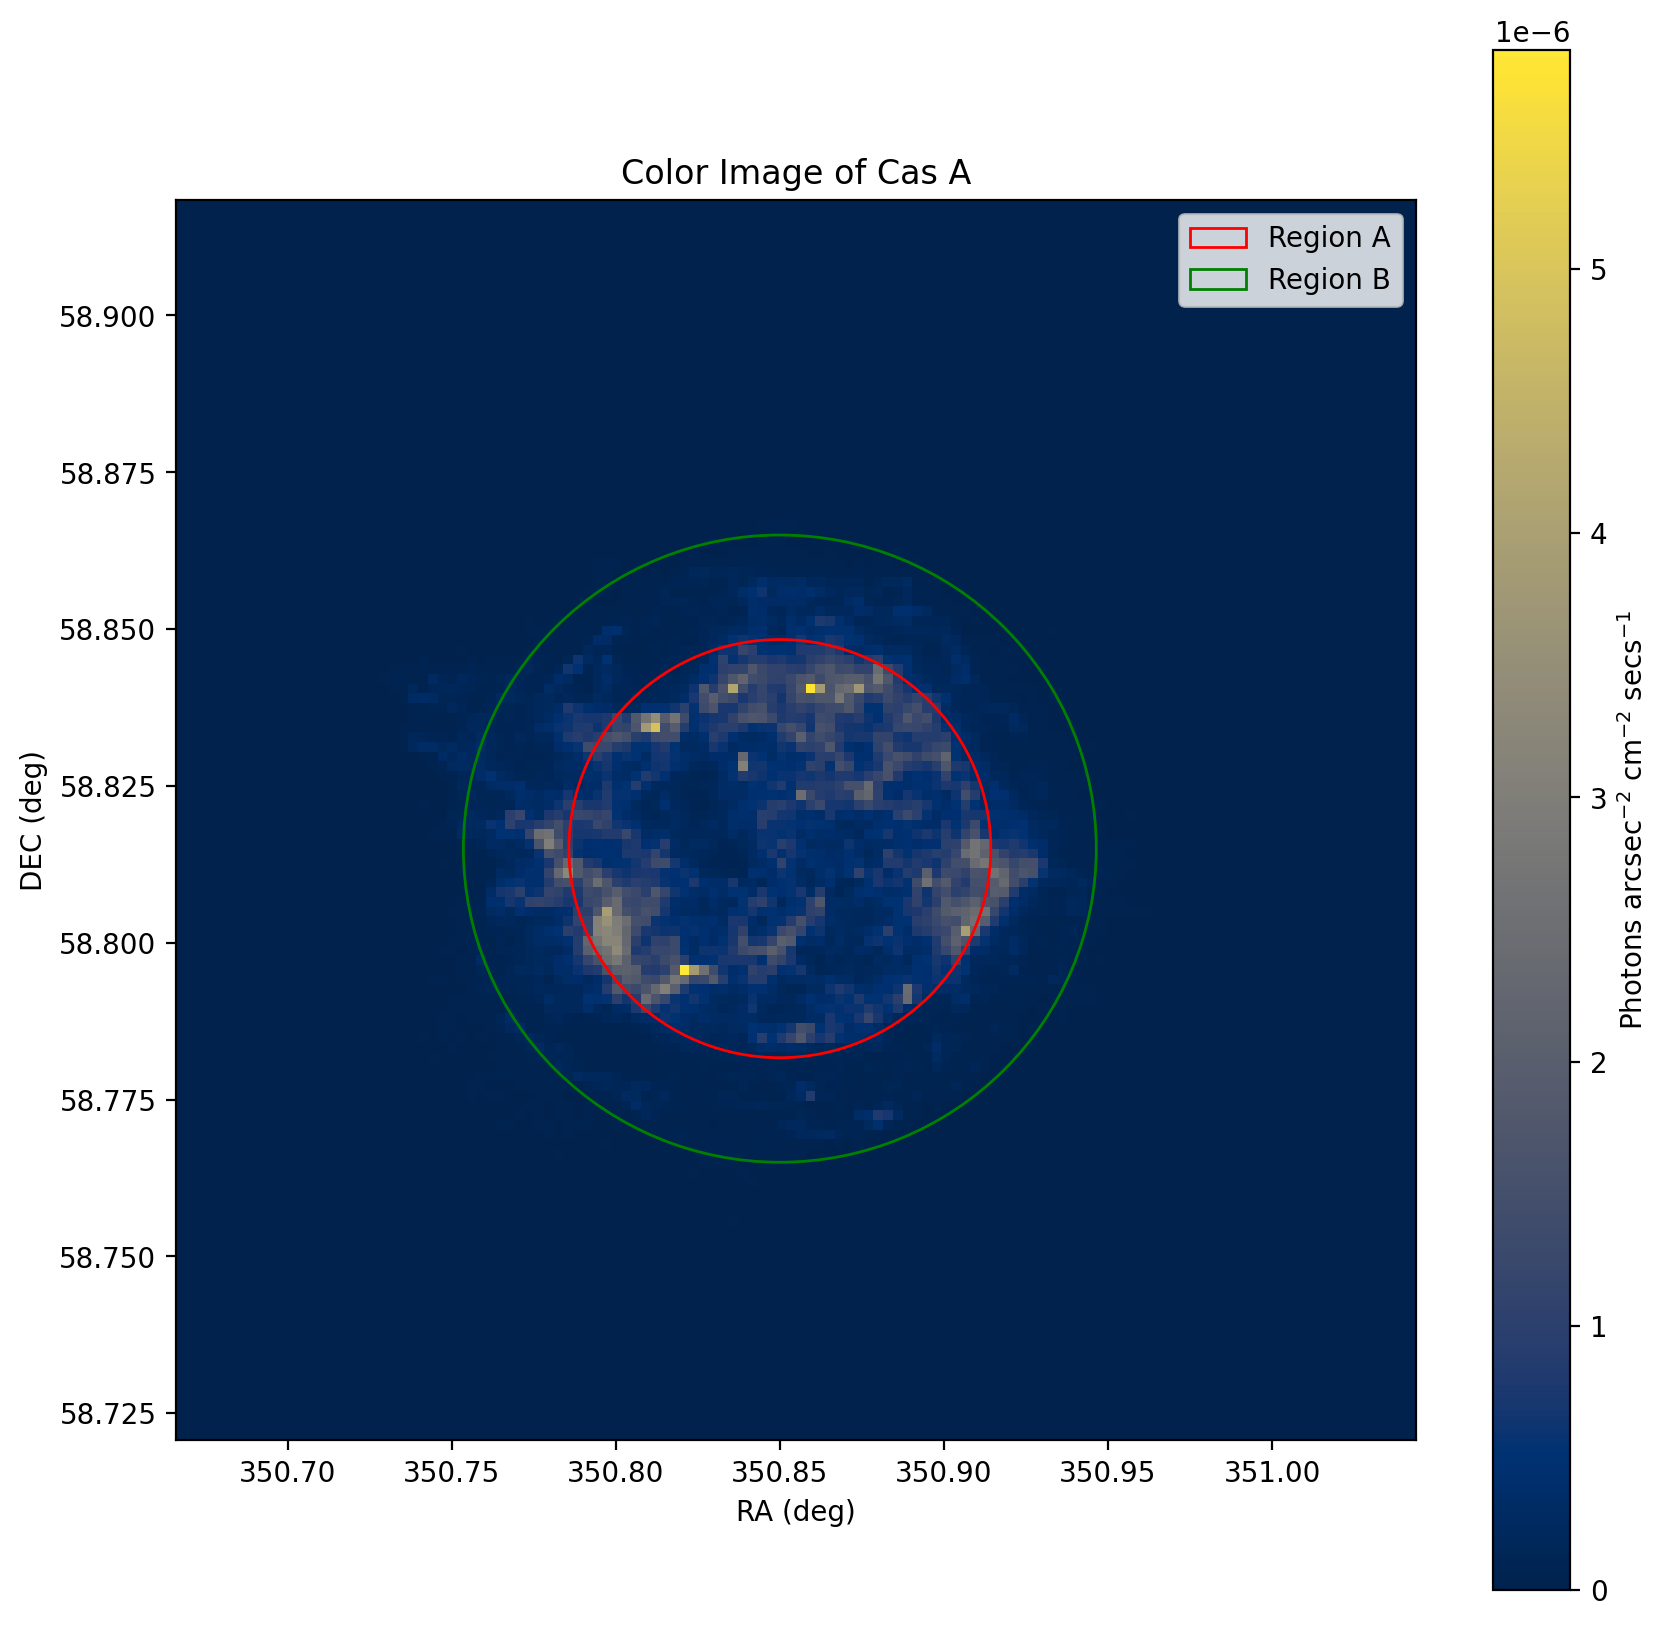

In [7]:
# Code here
from astropy import units as u
from matplotlib.patches import Ellipse
from astropy.coordinates import SkyCoord
from astropy import units as u
center = SkyCoord("23h23m24s","+58d48m54s",frame='icrs')
center_ra= center.ra.deg
center_dec = center.dec.deg
A_rad = (2*u.arcmin).to(u.deg)
B_rad2 = (3*u.arcmin).to(u.deg)
A = Ellipse((center_ra, center_dec), 2*A_rad.value/np.cos(d0),\
         2*A_rad.value, edgecolor='r', facecolor='none',label='Region A')
B2 = Ellipse((center_ra, center_dec), 2*B_rad2.value/np.cos(d0),\
         2*B_rad2.value, edgecolor='g', facecolor='none',label='Region B')

plt.figure(figsize=(10,10),dpi=200)
R = (np.max(RA) - np.min(RA)) / (np.max(DEC) - np.min(DEC))
plt.imshow(image, cmap = 'cividis', origin = 'lower',\
           extent = [np.min(RA),np.max(RA),np.min(DEC),np.max(DEC)],\
            aspect = R)
plt.colorbar(label=r'Photons arcsec$^{-2}$ cm$^{-2}$ secs$^{-1}$',norm='log')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.title('Color Image of Cas A')

ax = plt.gca()
ax.add_patch(A)
ax.add_patch(B2)
plt.legend()
plt.show()

## Extra credit

**e)** Return to the original file data and select photons by position so that you have two
NumPy record arrays, one containing photon energies for photons arriving in region “A”
and the other containing energies for photons in region “B.”  Apart from using the positions to select photons from the two regions we will now be interested only in their energies. Hint: you can use the coordinates of each photon to create a SkyCoord object and compute its distance to the center -- see Reading 14 again.

...

Write code to create a second plot showing spectra for the two regions (two curves on
one plot). The spectra should be shown as “step”-type histograms of photon counts per
cm$^2$ per second per keV versus photon energy in keV. Both x and y axes should be
logarithmic, with ranges chosen to allow the curves to fill most of the plot. Include a
legend, appropriate axis labels (remember units!), and an appropriate title. In choosing
the bin size for each curve (they do not have to be the same), ensure that at least 10
photons contribute to each bin. You will need to experiment with the bin size to find the
appropriate value.

When constructing photon energy histograms, keep in mind that the NumPy or Matplotlib histogram routines will return data that are effectively in units of photons per bin. So to get the spectra in the desired units you need to divide the histograms by effective area in cm$^2$, live time in seconds, and bin width in keV.

In [8]:
# Code here

In [9]:
%%capture
# Here we use a script to generate pdf and save it to google drive.

# After executing this cell, you will be asked to link to your GoogleDrive account.
# Then, the pdf will be generated and saved to your GoogleDrive account and you need to go there to download;

from google.colab import drive
drive.mount('/content/drive')
# install tex; first run may take several minutes
! apt-get install texlive-xetex
# file path and save location below are default; please change if they do not match yours
! jupyter nbconvert --output-dir='/content/drive/MyDrive/' '/content/drive/MyDrive/Colab Notebooks/ASTR 310 HW8.ipynb' --to pdf

ModuleNotFoundError: No module named 'google.colab'